In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import json
import string
from string import punctuation


In [2]:
df_data100 = pd.read_csv('activity_data_100.csv')
df_activities = pd.read_csv('activities.csv')
df_story = pd.read_csv('story.csv')
df_utterance = pd.read_csv('utterance.csv')

In [3]:
numPhrases = len(df_story)
numWords = len(df_utterance)
IDs_Cleaned = False

# Data Cleaning

#### Lets get a clean version of the story and phrases

Not yet sure which data structure is going to be most useful so prestaging both



In [16]:
table = str.maketrans('', '', string.punctuation)
phrases = {}
story = []

def cleanStory(df_story, phrases, story):
    for i, phrase in enumerate(df_story['phrase']):
        # split into words by white space
        words = phrase.lower().split()
        # remove punctuation from each word    
        stripped = [w.translate(table) for w in words]
        phrases[i] = stripped
        story.extend(stripped)


#### Lets clean up those activity Ids

In [5]:
def cleanData(df_data100):
    for i in range(len(df_data100)):
        df_data100['activityId'][i] = df_data100['activityId'][i][:-4]

In [6]:
def cleanUtterances(df_utterance):
    for i in range(len(df_utterance)):
        df_utterance['activityId'][i] = df_utterance['activityId'][i][:-4]


In [7]:
def cleanActivities(df_activities):
    for i in range(len(df_activities)):
        df_activities['activityId'][i] = df_activities['activityId'][i][:-4]

In [8]:
'''
Cleaning chunks off last 4 of ActivityId's, running more than once keeps chopping. 
(could just make copy, but this is fine)
'''

if not IDs_Cleaned:
    cleanStory(df_story, phrases, story)
    cleanData(df_data100)
    cleanUtterances(df_utterance)
    cleanActivities(df_activities)
    IDs_Cleaned = True

/home/matthew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Lets try to structure the transcription services
#### A niave transcription cleaning script. This function will correctly identify and label individual words either poorly transcribed or missed by the student. Fails under the condition of greater than 2 consecutive missed / altered words. Could expand using minimum permutation estimation but not in scope

In [9]:
def cleanTranscription(Transcription_Phrases, phrases):
    for phraseNum in range(numPhrases):
        cleanPhrase = []
        missed = set()
        k = p = 0
        while k < len(Transcription_Phrases[phraseNum]) and p < len(phrases[phraseNum]):
            if phrases[phraseNum][p] == Transcription_Phrases[phraseNum][k]:
                cleanPhrase.append(Transcription_Phrases[phraseNum][k])
                p += 1
                k += 1
            elif k+1  < len(Transcription_Phrases[phraseNum]) and phrases[phraseNum][p] == Transcription_Phrases[phraseNum][k+1]:
                k += 1
            elif p+1 < len(phrases[phraseNum]) and phrases[phraseNum][p+1] == Transcription_Phrases[phraseNum][k]:
                cleanPhrase.append(-1)
                p += 1
            else:
                cleanPhrase.append(-1)
                p += 1
                k += 1                
                
        if k == len(Transcription_Phrases[phraseNum]):
            while p < len(phrases[phraseNum]):
                cleanPhrase.append(-1)
                p += 1
                
        if p == len(phrases[phraseNum]):
            Transcription_Phrases[phraseNum] = cleanPhrase

#### Kaldi
Seems to be a fairly straight forwards JSON format, but poor quality transcription. I think for this naive data analysis task its best to filter for confidence. 

In [10]:
kaldi_Phrases = {}

def parseKaldi(kaldi_Phrases, df_data100):
    for i in range(numPhrases):
        kaldi_Phrases[i] = []
        ks = df_data100['kaldi_transcription'][i]
        y = json.loads(ks)
        for j in range(len(y)):
            if y[j]['confidence'] > 0.95:
                kaldi_Phrases[i].append(y[j]['word'])
            
    
phrase_check = 1
parseKaldi(kaldi_Phrases, df_data100)
cleanTranscription(kaldi_Phrases, phrases)
print('Expected Phrase: ', phrases[phrase_check])
print('Kaldi Captured Phrase: ', kaldi_Phrases[phrase_check])

Expected Phrase:  ['adam', 'didnt', 'play', 'with', 'anybody']
Kaldi Captured Phrase:  ['adam', 'didnt', 'play', 'with', 'anybody']


#### PocketSphinx
Also fairly straight forward JSON format, same strategy of confidence filtering

In [11]:
Sphinx_Phrases = {}

def parseSphinx(Sphinx_Phrases, df_data100):
    for i in range(numPhrases):
        Sphinx_Phrases[i] = []
        ss = df_data100['pocketsphinx_word_confidence'][i]
        y = json.loads(ss)
        for j in range(len(y)):
            if y[j][1] == 1:
                stripped = y[j][0].translate(table)
                Sphinx_Phrases[i].append(stripped.lower())
                
            
phrase_check = 22
parseSphinx(Sphinx_Phrases, df_data100)
cleanTranscription(Sphinx_Phrases, phrases)
print('Expected Phrase:')
print('\t', phrases[phrase_check])
print('Pocket Sphinx Captured Phrase: ')
print('\t', Sphinx_Phrases[phrase_check])

Expected Phrase:
	 ['maybe', 'if', 'were', 'nice', 'to', 'him', 'hell', 'start', 'to', 'be', 'a', 'little', 'nicer', 'to', 'us']
Pocket Sphinx Captured Phrase: 
	 ['maybe', 'if', 'were', 'nice', 'to', 'him', 'hell', 'start', -1, 'be', 'a', 'little', 'nicer', 'to', 'us']


#### Google and Amazon
The google and Amazon transcription service API descriptions both claim JSON. These format fails to meet JSON standards. I have attempted to correct individual discrepencies but continue to find more. 

Amazon's format can be operated on from splitting and cleaning their transcriptions without filtering for confidence. If I had more time, or perhaps knew of the correct API I would want to use the confidence metric to build out features ie. vectorize the transcriptions and build a feature set of the type [word_vec1, conf1, word_vec2, conf2, word_vec3, conf3, word_vec, conf4, expected_word_vec]

In [12]:
# Not operating on Google transcription
G = df_data100['google_output'][0]
A = df_data100['amazon_transcript'][0]

Amazon_Phrases = {}
def parseAmazon(Amazon_Phrases, df_data100):
    for i in range(numPhrases):
        Amazon_Phrases[i] = []
        A = df_data100['amazon_transcript'][i].lower().split()
        stripped = [w.translate(table) for w in A]
        Amazon_Phrases[i] = stripped


phrase_check = 22
parseAmazon(Amazon_Phrases, df_data100)
cleanTranscription(Amazon_Phrases, phrases)
print('Expected Phrase:')
print('\t', phrases[phrase_check])
print('Amazon Captured Phrase: ')
print('\t', Amazon_Phrases[phrase_check])

Expected Phrase:
	 ['maybe', 'if', 'were', 'nice', 'to', 'him', 'hell', 'start', 'to', 'be', 'a', 'little', 'nicer', 'to', 'us']
Amazon Captured Phrase: 
	 ['maybe', 'if', 'were', 'nice', 'to', 'him', 'hell', 'start', -1, -1, 'a', 'little', 'nicer', 'to', 'us']


# Exploratory Data Analysis

#### Lets Make a histogram of number of errors per child

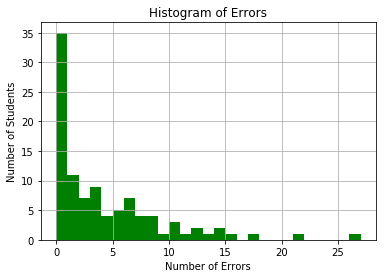

In [13]:
errors = {}
word_error = {}
word_error['truth_errors'] = []

for word in story:
    if word not in word_error:
        word_error[word] = 0
            
for i in range(len(df_utterance)):
    if df_utterance['activityId'][i] not in errors:
        errors[df_utterance['activityId'][i]] = 0
        
    if df_utterance['Utterance'][i][:6] == 'abcabc':
        errors[df_utterance['activityId'][i]] += 1
        word = df_utterance['Utterance'][i][6:]
        if word not in word_error: 
            word_error['truth_errors'].append(word)
        else:          
            word_error[word] += 1
            
max_errors = 0
histErrors = []
for key in errors:
    histErrors.append(errors[key])
    if errors[key] > max_errors:
        max_errors = errors[key]
    
# the histogram of the data
_, bins, _ = plt.hist(histErrors, max_errors, facecolor='green')

plt.xlabel('Number of Errors')
plt.ylabel('Number of Students')
plt.title('Histogram of Errors')
plt.grid(True)
plt.rcParams['figure.dpi'] = 250
plt.show()
    

#### Lets see which words they are missing

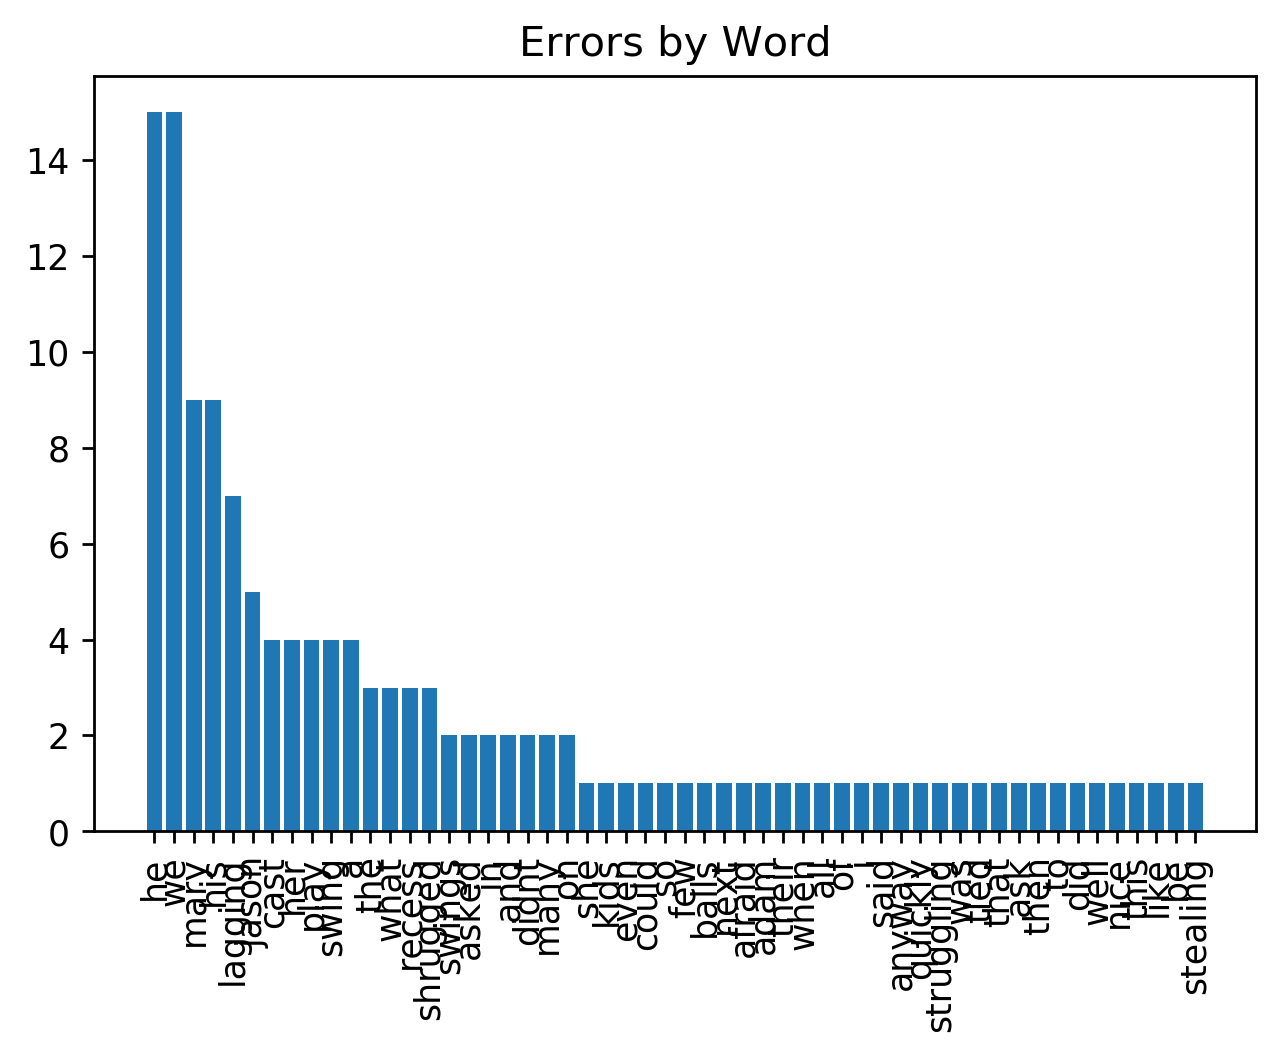

In [14]:
Words = []
WordNums = []

for key, value in word_error.items():
    if key == 'truth_errors':
        continue
    if value:
        Words.append(key)
        WordNums.append(value)

numWords = [i+1 for i in range(len(Words))]
Words = numpy.array(Words)
WordNums = numpy.array(WordNums)
inds = WordNums.argsort()[::-1]
Words = Words[inds]
WordNums = WordNums[inds]

plt.bar(numWords, WordNums, align='center')
plt.xticks(numWords, Words, rotation='vertical')
plt.title('Errors by Word')
plt.rcParams['figure.dpi'] = 200
plt.show()